In [1]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.datasets import imdb



# Reformatting the text data



In [2]:
from sklearn.utils import resample
(x_train, y_train), (x_test, y_test)= imdb.load_data(num_words =10000)
x_unlabeled = resample(x_train, n_samples=15000, replace=False, stratify=x_train, random_state=0)

17464789/17464789 [==============================] - 2s 0us/step


In [3]:
from keras.preprocessing.text import Tokenizer

max_words = 10000
num_classes = max(y_train) + 1

tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
x_unlabeled_ = tokenizer.sequences_to_matrix(x_unlabeled, mode='binary')

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print(x_train[0])
print(len(x_train[0]))

print(y_train[0])
print(len(y_train[0]))


[0. 1. 1. ... 0. 0. 0.]
10000
[0. 1.]
2


In [4]:
#for embedding purposes makes sure all samples are of the same length
from keras import preprocessing
maxlen = 1000 #max 100 words per input
x_train_ =tf.keras.utils.pad_sequences(x_train, maxlen = maxlen)
x_test_ = tf.keras.utils.pad_sequences(x_test, maxlen = maxlen)

In [5]:
x_test[:700][0].shape

(10000,)

# Defining Functions

In [ ]:
#fit the data


In [ ]:
!nvcc --version

1.- Train model on a batch of labeled data <br>
2.- Use the trained model to predict labels on a batch of unlabeled data<br>
3.- Use the predicted labels to calculate the loss on unlabeled data<br>
4.- Combine labeled loss with unlabeled loss and backpropagate<br>

In [5]:
from tensorflow.python.ops.numpy_ops import np_config
class CustomModel(tf.keras.Model):

  def train_step(self, data):

    # Unpack the data. Its structure depends on your model and
    # on what you pass to `fit()`.
    x, y = data

    with tf.GradientTape() as tape:

        y_pred = self(x, training=True)  # Forward pass
        y_pred = tf.reshape(y_pred, (700, 2))
        #y_pred = np_config.reshape(y_pred, (len(y_pred), 2))
        # Compute the loss value
        # (the loss function is configured in `compile()`)
        
        loss = self.compiled_loss(y, y_pred)#, regularization_losses=self.losses)

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    # Update metrics (includes the metric that tracks the loss)
    self.compiled_metrics.update_state(y, y_pred)
    # Return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}

In [ ]:
from keras.metrics import categorical_accuracy, categorical_crossentropy
from keras.utils import to_categorical

class CustomCallback(tf.keras.callbacks.Callback):

  def __init__(self):
    self.alpha_w = 0.0
    self.n_classes=2

  def on_epoch_end(self, epoch, logs):
    if epoch < 10:
        self.alpha_w = 0.0
    elif epoch >= 70:
        self.alpha_w = 3.0
    else:
        self.alpha_w = (epoch - 10.0) / (70.0-10.0) * 3.0
    
    #coefs =(1+ self.alpha_w)
    #logs["loss"] = logs["loss"]*coefs

  def loss_function(self, y, y_pred):

    #y_batch, np.repeat(0.0, y_batch.shape[0])
    #cce = tf.keras.losses.SparseCategoricalCrossentropy()
    #y = np.c_[y, np.repeat(0.0, y.shape[0])]
    #y_true_item = y[:, :self.n_classes]
    #unlabeled_flag = y[:, self.n_classes]
    """
    from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](https://en.wikipedia.org/wiki/Logit) values. By default, we
            assume that `y_pred` contains probabilities (i.e., values in [0,
            1]).
    """
    entropies = categorical_crossentropy(y, y_pred)
    coefs = 1 + self.alpha_w
    self.loss = coefs * entropies
    #1.0-unlabeled_flag + self.alpha_w * unlabeled_flag # 1 if labeled, else alpha_t
    return coefs * entropies

  def accuracy(self, y, y_pred):

    y_true_item = y[:, :self.n_classes]
    return categorical_accuracy(y_true_item, y_pred)
  

In [11]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=True,
                                                 verbose=1)

In [14]:
def model_():
  inputs = tf.keras.Input(shape=(maxlen,))
  embedding = tf.keras.layers.Embedding(maxlen, 5)(inputs)
  lstm = tf.keras.layers.LSTM(5)(embedding)
  #flat = tf.keras.layers.Flatten()(embedding) no need to flatten?
  layer = tf.keras.layers.Dense(512, activation ="relu")(lstm)
  drop = tf.keras.layers.Dropout(0.5)(layer)
  outputs = tf.keras.layers.Dense(num_classes, activation = "softmax")(drop)

  model = CustomModel(inputs, outputs)

  c_backs =CustomCallback()
  model.compile(loss=c_backs.loss_function, optimizer='adam', metrics=[c_backs.accuracy])
  return model

In [13]:
import numpy as np

# Construct and compile an instance of CustomModel max_words
#maxlen = 1000
inputs = tf.keras.Input(shape=(maxlen,))
embedding = tf.keras.layers.Embedding(maxlen, 5)(inputs)
lstm = tf.keras.layers.LSTM(5)(embedding)
#flat = tf.keras.layers.Flatten()(embedding) no need to flatten?
layer = tf.keras.layers.Dense(512, activation ="relu")(lstm)
drop = tf.keras.layers.Dropout(0.5)(layer)
outputs = tf.keras.layers.Dense(num_classes, activation = "softmax")(drop)

model = CustomModel(inputs, outputs)

c_backs =CustomCallback()
model.compile(loss=c_backs.loss_function, optimizer='adam', metrics=[c_backs.accuracy])



#training with the labeled data 100 times first
#model.fit(x_train_, y_train, epochs=10)

In [16]:
num_classes=2

model.save_weights(filepath.format(epoch=0))
for i in range(10):
  #for every odd i fir with labeled data
  if i%2 == 0:
    #fitting with labeled data
    
    model.fit(x_train_, y_train, epochs = 20, verbose =2, batch_size = 700,\
              validation_data=(x_test_[:700], y_test[:700]), callbacks =[c_backs, cp_callback])
    
    latest = tf.train.latest_checkpoint(filepath)
  else:
    #getting pseudo labels
    x_unlabeled_sam = resample(x_unlabeled_, n_samples=1000, replace=False, stratify=x_unlabeled, random_state=0)
    x_unlabeled_sam =tf.keras.utils.pad_sequences(x_unlabeled_sam, maxlen = maxlen)
    pseudo_labels = model.predict(x_unlabeled_sam)
    pseudo_labels_ =np.argmax(pseudo_labels, axis=-1,).reshape(-1, 1)
    pseudo_labels_ = tf.keras.utils.to_categorical(pseudo_labels_, num_classes)

    #starting another model
    model = model_()
    #loading previous weighths
    model.load_weights(latest)
    #fitting new model with old weights
    history = model.fit(x_unlabeled_sam, pseudo_labels_, epochs = 30, verbose =2, \
                        callbacks=[c_backs, cp_callback], batch_size = 500, \
                        validation_data=(x_test_[:700], y_test[:700]) )
    #savig latest weights from pseudo labels
    #latest = tf.train.latest_checkpoint(filepath)
    
    
    
  

Epoch 1/20

Epoch 1: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
36/36 - 4s - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.4786 - 4s/epoch - 119ms/step
Epoch 2/20

Epoch 2: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
36/36 - 1s - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6934 - val_accuracy: 0.4786 - 1s/epoch - 36ms/step
Epoch 3/20

Epoch 3: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
36/36 - 1s - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5214 - 1s/epoch - 36ms/step
Epoch 4/20

Epoch 4: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
36/36 - 1s - loss: 0.6933 - accuracy: 0.5028 - val_loss: 0.6936 - val_accuracy: 0.4786 - 1s/epoch - 36ms/step
Epoch 5/20

Epoch 5: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
36/36 - 1s - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4786 - 1s/epoch - 36ms/step
Epoch 6/20

Epoch 6: saving model to /conten

Epoch 1/30

Epoch 1: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 3s - loss: 0.8325 - accuracy: 0.0000e+00 - val_loss: 0.6969 - val_accuracy: 0.5214 - 3s/epoch - 1s/step
Epoch 2/30

Epoch 2: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8421 - accuracy: 0.0000e+00 - val_loss: 0.6961 - val_accuracy: 0.5214 - 191ms/epoch - 96ms/step
Epoch 3/30

Epoch 3: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8275 - accuracy: 0.0000e+00 - val_loss: 0.6946 - val_accuracy: 0.5214 - 194ms/epoch - 97ms/step
Epoch 4/30

Epoch 4: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8057 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.5214 - 181ms/epoch - 90ms/step
Epoch 5/30

Epoch 5: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.7765 - accuracy: 0.0000e+00 - val_loss: 0.6924 - val_accuracy: 0.5214 - 177ms/epoch - 89ms/step
Epoch 6/30

Epoch 6: savi

Epoch 1/30

Epoch 1: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 3s - loss: 0.8326 - accuracy: 0.0000e+00 - val_loss: 0.6969 - val_accuracy: 0.5214 - 3s/epoch - 1s/step
Epoch 2/30

Epoch 2: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8420 - accuracy: 0.0000e+00 - val_loss: 0.6961 - val_accuracy: 0.5214 - 195ms/epoch - 98ms/step
Epoch 3/30

Epoch 3: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8275 - accuracy: 0.0000e+00 - val_loss: 0.6946 - val_accuracy: 0.5214 - 178ms/epoch - 89ms/step
Epoch 4/30

Epoch 4: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8041 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.5214 - 195ms/epoch - 98ms/step
Epoch 5/30

Epoch 5: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.7770 - accuracy: 0.0000e+00 - val_loss: 0.6924 - val_accuracy: 0.5214 - 178ms/epoch - 89ms/step
Epoch 6/30

Epoch 6: savi

Epoch 1/30



Epoch 1: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 3s - loss: 0.8330 - accuracy: 0.0000e+00 - val_loss: 0.6969 - val_accuracy: 0.5214 - 3s/epoch - 2s/step
Epoch 2/30

Epoch 2: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8423 - accuracy: 0.0000e+00 - val_loss: 0.6961 - val_accuracy: 0.5214 - 213ms/epoch - 106ms/step
Epoch 3/30

Epoch 3: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8285 - accuracy: 0.0000e+00 - val_loss: 0.6946 - val_accuracy: 0.5214 - 184ms/epoch - 92ms/step
Epoch 4/30

Epoch 4: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8040 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.5214 - 200ms/epoch - 100ms/step
Epoch 5/30

Epoch 5: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.7770 - accuracy: 0.0000e+00 - val_loss: 0.6924 - val_accuracy: 0.5214 - 186ms/epoch - 93ms/step
Epoch 6/30

Epoch 6: saving model 

Epoch 1/30

Epoch 1: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 3s - loss: 0.8337 - accuracy: 0.0000e+00 - val_loss: 0.6969 - val_accuracy: 0.5214 - 3s/epoch - 1s/step
Epoch 2/30

Epoch 2: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8410 - accuracy: 0.0000e+00 - val_loss: 0.6961 - val_accuracy: 0.5214 - 200ms/epoch - 100ms/step
Epoch 3/30

Epoch 3: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8284 - accuracy: 0.0000e+00 - val_loss: 0.6946 - val_accuracy: 0.5214 - 217ms/epoch - 108ms/step
Epoch 4/30

Epoch 4: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8048 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.5214 - 187ms/epoch - 94ms/step
Epoch 5/30

Epoch 5: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.7767 - accuracy: 0.0000e+00 - val_loss: 0.6924 - val_accuracy: 0.5214 - 200ms/epoch - 100ms/step
Epoch 6/30

Epoch 6: s

Epoch 1/30

Epoch 1: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 3s - loss: 0.8329 - accuracy: 0.0000e+00 - val_loss: 0.6969 - val_accuracy: 0.5214 - 3s/epoch - 1s/step
Epoch 2/30

Epoch 2: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8417 - accuracy: 0.0000e+00 - val_loss: 0.6961 - val_accuracy: 0.5214 - 202ms/epoch - 101ms/step
Epoch 3/30

Epoch 3: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8287 - accuracy: 0.0000e+00 - val_loss: 0.6946 - val_accuracy: 0.5214 - 210ms/epoch - 105ms/step
Epoch 4/30

Epoch 4: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.8040 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.5214 - 194ms/epoch - 97ms/step
Epoch 5/30

Epoch 5: saving model to /content/gdrive/MyDrive/den_yelp_notebooks/
2/2 - 0s - loss: 0.7763 - accuracy: 0.0000e+00 - val_loss: 0.6924 - val_accuracy: 0.5214 - 188ms/epoch - 94ms/step
Epoch 6/30

Epoch 6: sa

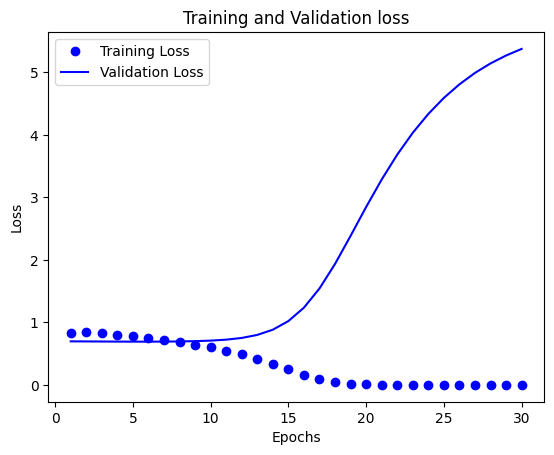

In [17]:

h_d = history.history
loss_values = h_d['loss']
val_loss_values = h_d["val_loss"]
epochs = range(1, len(h_d['accuracy'])+1)

plt.plot(epochs, loss_values, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss_values, 'b', label="Validation Loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()